In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

<center><h2>Jupyter Notebook para entender el modelamiento matemático de las GANs y ponerlo en práctica.</h2></center><br>
<b>Autor:</b> Edwin Jahir Rueda Rojas<br>
<b>email:</b> ejrueda95g@gmail.com<br>
<b>website:</b> edwinrueda.com<br>
<b>github:</b> https://github.com/ejrueda<br><br>
Todo el contenido aquí realizado se basa en el artículo publicado por Ian J. Goodfellow et al. Titulado: <i><b>Generative Adversarial Nets</b></i>. (https://arxiv.org/abs/1406.2661)

<h1>Arquitectura GAN</h1><br>
- Se entrenan dos modelos G y D simultaneamente, en los cuales el modelo generativo G captura la distribuición de los datos reales, y el modelo discriminativo D estima la probabilidad de que dado un ejemplo, este sea de la distribuición original o no.

#### Objetivo:
- El objetivo de esta red es entrenar la red generadora G para maximizar la probabilidad de que la red Discriminadora D cometa errores de intendificación de la distribuición. Esto corresponde a un juego de mini-max entre dos jugadores, y solo existe una única solución, la cual ocurre cuando la red Generadora G capta la distribuición de los datos y así la red Discriminadora D no consigue diferenciar los ejemplos, teniendo así 0.5 de acierto.

Cabe aclarar que esto se puede implementar con dos redes perceptrones multicapa utilizando el algoritmo <i>backpropagation</i> para el entrenamiento.

## Ejemplo práctico
- Para nuestro ejemplo práctico, se tomará tomará una base de datos de genes y se trataŕa de generar nuevos genes a partir del modelamiento de la distribuición que aprenderá la red Generadora.

### Red Generadora G
- Se toma una distribuición Gaussiana como entrada a la red Generadora para así generar los datos sintéticos (fake).
- Con la red generadora lo que se quiere es ir del espació de datos de la distribuición inicial, a el espacio de datos de la distribuición que se quiere replicar, por eso la salida de esta red no es un simple escalar como en un problema de clasificación, esta red tiene como salida los datos que la red cree que pertenecen al espacio original.

In [2]:
def generator(noise_input, out_dim):
    """
    noise_input: vector con los datos de la distribuición inicial
    out_dim: dimension de la salida esperada, por ejemplo si es una imagen
             en escala de gris, sería out_dim: (32,32,1)
    Retorna el modelo Generador
    """
    model = Sequential()
    model.add(Dense(256, input_shape=(noise_input,)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(.1))
    model.add(Dense(np.prod(out_dim), activation="tanh"))
    model.add(Reshape(out_dim))
    
    return model

In [3]:
noise_input = 100
print("Dimension del ruido de entrada: ",noise_input)
G = generator(noise_input, out_dim=(9,))
optimizerG = Adam(lr=0.0004, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=optimizerG)

Dimension del ruido de entrada:  100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 2313      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 28,169
Trainable params: 28,169
Non-trainable params: 0
_________________________________________________________________


In [5]:
noise = np.random.normal(loc=0, scale=1, size=(50,100))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (50, 100)
Dimension de los ejemplos generados: (50, 9)


### Red discriminadora D
- La red discriminadora funciona como una red clasificadora, la cual tendrá dos categorias, 0 si los datos son de la distribuición real y 1 si los datos vienen de la distribuición falsa (fake).

In [6]:
def discriminator(input_dim):
    """
    input_dim: dimension de los datos de entrada,
               por ejemplo si es una imagen en escala de gris,
               sería input_dim: (32,32,1)
    """
    model = Sequential()
    model.add(Dense(32, input_shape=input_dim))
    model.add(LeakyReLU(alpha=0.2)) #función rectificadora
    model.add(Dropout(.1))
    model.add(Dense(32))
    model.add(Flatten())
    #activación sigmoid ya que se precisa establecer si es 0 ó 1.
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
D = discriminator((9,))
optimizerD = Adam(lr=0.0001, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=optimizerD, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Red GAN
- La red GAN está creada conectando tanto la red G como la red D de forma secuencial, recordando que la red D debe ser entrenada de forma separada, para que el algoritmo de <i>backpropagation</i> no afecte los pesos de la red G, asi, una vez la red D se entrene, se procede a entrenar la GAN, la cual mudará solo los pesos de la red G, ya que los de la red D no se pueden actualizar en este paso. Esto se repite la cantidad de <i>epochs</i> que se definan.

In [8]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [9]:
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 9)                 28169     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409      
Total params: 29,578
Trainable params: 28,169
Non-trainable params: 1,409
_________________________________________________________________


### Entrenamiento de la red
- Para entrenar la red, primero se creará una función con la cual se obtendrán los <i>bacth</i> con los cuales se entrenara la red en cada <i>epochs</i>.
- Como se mencionó anteriormente, en cada <i>epochs</i> la red discriminadora D es entrenada a parte y luego es entrenada la red GAN, recordando que esta solo actualiza los pesos de la red generadora G mediante <i>backpropagation</i>.

In [10]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [11]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_l = D.train_on_batch(x_combined_batch, y_combined_batch)
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))

            g_l = gan.train_on_batch(noise, y_mislabled)
 
        t_f = time()
        t = t_f - t_i
        t_i = time()
        d_loss.append(d_l[0])
        g_loss.append(g_l)
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        
    return g_loss, d_loss

In [12]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


In [13]:
max_val = 1
min_val = -1
X_train = ((X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)))*(max_val - min_val) + min_val

In [14]:
X_train.shape

(4051, 9)

In [15]:
ep = 100
g_loss, d_loss = train(X_train, epochs=ep, batch_size=32, G=G, D=D, gan=gan, noise_input=100)

epoch:[1/100] [Discriminator::d_loss: 0.696925],[Generator::loss: 0.682230], 1.810640[sec]
epoch:[2/100] [Discriminator::d_loss: 0.727474],[Generator::loss: 0.667597], 0.819443[sec]
epoch:[3/100] [Discriminator::d_loss: 0.683857],[Generator::loss: 0.773410], 0.820726[sec]
epoch:[4/100] [Discriminator::d_loss: 0.653054],[Generator::loss: 0.798441], 0.869345[sec]
epoch:[5/100] [Discriminator::d_loss: 0.678749],[Generator::loss: 0.653326], 0.834114[sec]
epoch:[6/100] [Discriminator::d_loss: 0.679531],[Generator::loss: 0.769332], 0.855852[sec]
epoch:[7/100] [Discriminator::d_loss: 0.655300],[Generator::loss: 0.769057], 0.898130[sec]
epoch:[8/100] [Discriminator::d_loss: 0.662749],[Generator::loss: 0.771425], 0.952361[sec]
epoch:[9/100] [Discriminator::d_loss: 0.682209],[Generator::loss: 0.705284], 0.837830[sec]
epoch:[10/100] [Discriminator::d_loss: 0.668397],[Generator::loss: 0.731623], 0.814991[sec]
epoch:[11/100] [Discriminator::d_loss: 0.672104],[Generator::loss: 0.738191], 0.814484[se

epoch:[89/100] [Discriminator::d_loss: 0.695597],[Generator::loss: 0.692768], 0.889837[sec]
epoch:[90/100] [Discriminator::d_loss: 0.697904],[Generator::loss: 0.684438], 0.880280[sec]
epoch:[91/100] [Discriminator::d_loss: 0.693342],[Generator::loss: 0.690849], 0.923963[sec]
epoch:[92/100] [Discriminator::d_loss: 0.691995],[Generator::loss: 0.696965], 0.919555[sec]
epoch:[93/100] [Discriminator::d_loss: 0.692870],[Generator::loss: 0.691418], 0.897162[sec]
epoch:[94/100] [Discriminator::d_loss: 0.693863],[Generator::loss: 0.699585], 0.825281[sec]
epoch:[95/100] [Discriminator::d_loss: 0.696532],[Generator::loss: 0.695842], 0.849464[sec]
epoch:[96/100] [Discriminator::d_loss: 0.695293],[Generator::loss: 0.695121], 0.968748[sec]
epoch:[97/100] [Discriminator::d_loss: 0.693500],[Generator::loss: 0.689994], 0.974198[sec]
epoch:[98/100] [Discriminator::d_loss: 0.695241],[Generator::loss: 0.693924], 0.982965[sec]
epoch:[99/100] [Discriminator::d_loss: 0.696061],[Generator::loss: 0.693338], 0.

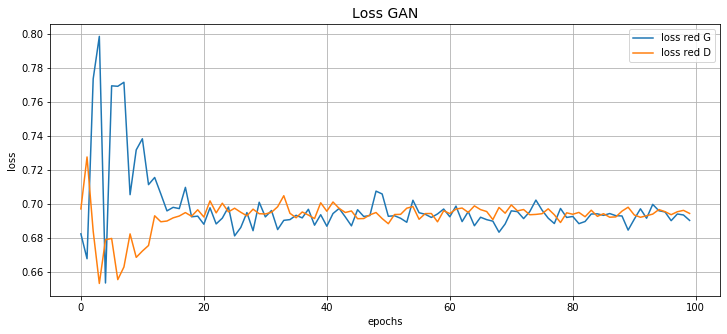

In [17]:
plt.figure(figsize=(12,5))
plt.title("Loss GAN", fontsize=14)
plt.plot(range(ep), g_loss, label="loss red G")
plt.plot(range(ep), d_loss, label="loss red D")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.legend();